# INTELIGENCIA COLECTIVA 
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

## Experimentando con Algoritmos de Inteligencia Colectiva

En este notebook se presenta la implementación de dos algoritmos de Inteligencia Colectiva para minimizar funciones continuas no convexas: el Algoritmo PSO y el Algoritmo ABC.  


### PARTICLE SWARM OPTIMIZATION (PSO) 


<b> Define clase Particle. Un Objeto de esta clase almacena informacion de una particula (solucion candidata) en PSO </b>

In [1]:
class Particle(object):
    """Clase Particle para almacenar informacion de una particula en PSO """
    
    def __init__(self, initial_position, initial_velocity, fitness): #constructor recibe posicion y velocidad inicial y fitness
        self.position = initial_position
        self.velocity = initial_velocity
        self.fitness = fitness
        self.best_position = initial_position
        self.best_fitness = fitness

<b> Define clase PSO. Un Objeto de esta clase instancia un optimizador PSO para un problema dado </b>

In [2]:
class PSO:
    """ Clase que implementa el optimizador PSO. El constructor puede recibir:
        fn: La funcion a ser minimizada
        PN: numero de particulas (
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        w: factor de inercia de la particula
        phi1: peso de aprendizaje cognitivo
        phi2: peso de aprendizaje social
        max_iter: número total de iteraciones que ejecutará PSO """

    def __init__(self, fn, PN, Xmin, Xmax, w, phi1, phi2, max_iter):  
        self.fn = fn
        self.PN = PN
        self.Xmin = np.array(Xmin)
        self.Xmax = np.array(Xmax)
        self.w = w
        self.phi1 = phi1
        self.phi2 = phi2
        self.max_iter = max_iter
        self.particles = []
        self.best_position_swarm = []
        self.best_fitness_swarm = []
        
    def fitness(self, position):  
        # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0. 
        # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf    
        result = self.fn(position)
        if result >= 0:
            fitness = 1 / (1 + result)
        else:
            fitness = 1 + abs(result)
        return fitness
        
    def create_particle(self):   # Instancia una particula aleatoria dentro de los limites de busqueda,
        position = self.Xmin + rand.random()*(self.Xmax - self.Xmin)
        Vmin = -1*(self.Xmax - self.Xmin)
        Vmax = (self.Xmax - self.Xmin)
        velocity = Vmin + rand.random()*(Vmax - Vmin)
        fitness = self.fitness(position)
        return Particle(position, velocity,fitness) 
    
    def initialize_particles(self):  # crea las SN particles de PSO
        self.particles = [self.create_particle() for i in range(self.PN)]
    
    def get_bestparticle(self):
        best = max(self.particles, key=attrgetter('fitness'))
        return best
        
    def optimize(self):
        start_time = time.time()
        print ('Iniciando optimizacion con Algoritmo PSO')
        self.initialize_particles() # inicializa el swarm de particulas
        
        history_bestfitness = []
        best_particle = self.get_bestparticle()
        self.best_position_swarm, self.best_fitness_swarm = deepcopy(best_particle.position), best_particle.fitness 
        history_bestfitness.append(self.best_fitness_swarm)  # almacena la historia de mejores fitness en cada ciclo
        print("Mejor solucion inicial = {}, fitness = {}".format(self.best_position_swarm, self.best_fitness_swarm))

        for g in range(self.max_iter):  # For each cycle

            for i in range(self.PN): # por cada particula en el swarm

                # si la particula i es mejor que la mejor posicion que ya vió la particula
                if self.particles[i].fitness > self.particles[i].best_fitness: 
                    self.particles[i].best_position = deepcopy(self.particles[i].position)
                    self.particles[i].best_fitness =  self.particles[i].fitness
                
                # si la mejor posicion que ya vió la particula i es mejor que la mejor position de todo el swarm
                if self.particles[i].best_fitness > self.best_fitness_swarm:
                    self.best_position_swarm = deepcopy(self.particles[i].best_position)
                    self.best_fitness_swarm  = self.particles[i].best_fitness
                    
            # Actualiza la velocidad y position de cada particula en el swarm
            for i in range(self.PN): 
                r1 = rand.random()
                r2 = rand.random()
                self.particles[i].velocity = self.w*self.particles[i].velocity + self.phi1*r1*(self.particles[i].best_position - self.particles[i].position) + self.phi2*r2*(self.best_position_swarm - self.particles[i].position) 
                self.particles[i].position = self.particles[i].position + self.particles[i].velocity
                self.particles[i].fitness  = self.fitness(self.particles[i].position)
                
             ## Obtiene la mejor posicion encontrada en este ciclo
            best_particle = self.get_bestparticle()  # mejor posicion del presente ciclo 
            history_bestfitness.append ( best_particle.fitness )
                
            if (g % 5 == 0): # muestra resultados cada 5 ciclos
                print("Ciclo {}, Mejor solucion del ciclo = {} (fitness = {}))".format(g, best_particle.position, best_particle.fitness ))
        
        end_time = time.time()
        print("Mejor solucion encontrada por PSO: {}, fitness = {}. Tomo {} seg ".format(self.best_position_swarm, self.best_fitness_swarm, end_time-start_time))
        return self.best_position_swarm, self.best_fitness_swarm, history_bestfitness
    

### ARTIFICIAL BEE COLONY (ABC) 


<b> Define clase FoodSource. Un Objeto de esta clase almacena informacion de una fuente de comida (solucion candidata) en ABC </b>


In [3]:
class FoodSource(object):
    """Clase FoodSource para almacenar informacion de una fuente de comida en ABC """
    
    def __init__(self, solution, fitness):  # el constructor recibe una posible solucion (localizacion) y su fitness
        self.solution = solution
        self.fitness = fitness
        self.trials = 0  # esta informacion almacena las veces que la fuente se ha intentado mejorar sin exito  

<b> Define clase ABC. Un Objeto de esta clase instancia un optimizador ABC para un problema dado </b>

In [4]:
import numpy as np
import time
import random as rand
from operator import attrgetter
from copy import deepcopy
import matplotlib.pyplot as plt

class ABC:
    """ Clase que implementa el optimizador ABC. El constructor puede recibir:
        fn: La funcion a ser minimizada
        SN: numero de fuentes de comida (Source Number)
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        limit: numero de ciclos que será conservada una solución sin mejorar antes de ser reemplazada 
        max_iter: número total de iteraciones que ejecutará ABC """

    def __init__(self, fn, SN, Xmin, Xmax, limit, max_iter ):  
        self.fn = fn
        self.SN = SN
        self.Xmin = np.array(Xmin)
        self.Xmax = np.array(Xmax)
        self.limit = limit
        self.max_iter = max_iter
        self.foodsources = []
    
    def fitness(self, solution):  
        # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0. 
        # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf    
            
        #return -1*self.fn(solution)
        result = self.fn(solution)
        if result >= 0:
            fitness = 1 / (1 + result)
        else:
            fitness = 1 + abs(result)
        return fitness
        
    def get_randomsolution(self, Xmin, Xmax):  # retorna una solucion generada aleatoriamente dentro de los limites Xmin y Xmax  
        r = rand.random()
        return  Xmin + r*(Xmax - Xmin)
        
    def create_foodsource(self):   # Instancia una fuente de comida aleatoria dentro de los limites de busqueda,
        solution = self.get_randomsolution(self.Xmin, self.Xmax)
        fitness = self.fitness(solution)
        return FoodSource(solution, fitness)   
    
    def initialize_foodsources(self):  # crea las SN fuentes de comida
        self.foodsources = [self.create_foodsource() for i in range(self.SN)]

    def produce_neighboursolution(self, foodsource_index):  # genera una solucion candidata en la vecindad de la fuente foodsource_index
        Xi = self.foodsources[foodsource_index].solution  # solucion de la fuente pasada
        other_source_indexes = list(range(self.SN)) 
        del(other_source_indexes[foodsource_index]) # remueve la fuente pasada para no ser seleccionada
        k = rand.choice(other_source_indexes)  # escoje aleatoriamente otra fuente para generar una solucion candidata 
        Xk = self.foodsources[k].solution  # solucion de la otra fuente
        r = rand.uniform(-1, 1)
        return  Xi + r * (Xi - Xk)
     
    def get_bestsolution(self, X, V):  # devuelve la solucion con mejor fitness entre la solucion actual X y una solucion candidata V 
        if self.fitness(V) > self.fitness(X):
            return V
        else:
            return X        

    def get_probs_foodsources(self): # calcula las probabilidades de las fuentes de comida
        fitness_sum = sum([fs.fitness for fs in self.foodsources])
        return [fs.fitness/fitness_sum  for fs in self.foodsources]
    
    def update_solution_foodsource(self, foodsource, new_solution):  # actualiza la solucion de la fuente de comida
        if np.array_equal(new_solution, foodsource.solution): # si es la misma solucion entonces solo aumenta trials de la fuente
            foodsource.trials += 1
        else: # si la nueva solucion es mejor que la actual de la fuente de comida -> actualiza solucion y fitness
            foodsource.solution = new_solution
            foodsource.fitness = self.fitness(new_solution)
            foodsource.trials = 0

    def selection(self, probabilities):  # selecciona una fuente de comida basada en sus probabilidades
        return rand.choices(range(self.SN), probabilities)[0]
    
    def get_bestfoodsource(self):
        best = max(self.foodsources, key=attrgetter('fitness'))
        return best
        
    def optimize(self):
        start_time = time.time()
        print ('Iniciando optimizacion con Algoritmo ABC')
        self.initialize_foodsources() # inicializa la poblacion de fuentes de comida
        
        history_bestfitness = []
        best_foodsource = self.get_bestfoodsource()
        best_solution, best_fitness = deepcopy(best_foodsource.solution), best_foodsource.fitness 
        history_bestfitness.append(best_fitness)  # almacena la historia de mejores fitness en cada ciclo
        print("Mejor solucion inicial = {}, fitness = {}".format(best_solution, best_fitness))

        for g in range(self.max_iter):  # For each cycle
            
            ## Etapa de Abejas empleadas (Employed bee)
            for i in range(self.SN): # por cada abeja empleada
                foodsource = self.foodsources[i]
                Vi = self.produce_neighboursolution(i)  # produce una solucion en la vecindad de foodsource 
                solution = self.get_bestsolution(foodsource.solution, Vi) # selecciona la mejor solucion entre la actual y la candidata
                self.update_solution_foodsource(foodsource, solution) # actualiza la solucion en la fuente escogida
            
            ## Etapa de Abejas Observadoras (Onlooker bee)
            for i in range(self.SN): # por cada abeja observadora
                probabilities = self.get_probs_foodsources()   # calcula las probabilidades de todas las fuentes de comida 
                index_foodsource = self.selection(probabilities) # selecciona una fuente de comida en base a las probabilidades (metodo ruleta)
                foodsource = self.foodsources[index_foodsource]
                Vi = self.produce_neighboursolution(index_foodsource)  # produce una solucion en la vecindad de selected_foodsource 
                solution = self.get_bestsolution(foodsource.solution, Vi) # selecciona la mejor solucion entre la fuente seleccionada actual y la candidata
                self.update_solution_foodsource(foodsource, solution)  # actualiza la solucion en la fuente escogida        
            
            ## Etapa de Abejas exploradoras (Scout bee)
            for i in range(self.SN): # por cada fuente de comida
                foodsource = self.foodsources[i]
                if foodsource.trials > self.limit:  # si el numero de veces que se intento mejorar la fuente excede el limite entonces abandona 
                    self.foodsources[i] = self.create_foodsource() # reemplaza la fuente de comida i  por una nueva 
            
             ## Memoriza la mejor solucion alcanzada hasta ahora 
            best_foodsource = self.get_bestfoodsource()  # mejor fuente del presente ciclo 
            history_bestfitness.append ( best_foodsource.fitness )
            if best_foodsource.fitness >  best_fitness:  # si la mejor solucion del ciclo es mejor que la mejor solucion histórica
                best_solution, best_fitness = deepcopy(best_foodsource.solution), best_foodsource.fitness
                
            if (g % 5 == 0): # muestra resultados cada 5 ciclos
                print("Ciclo {}, Mejor solucion del ciclo = {} (fitness = {}))".format(g, best_foodsource.solution, best_foodsource.fitness ))
        
        end_time = time.time()
        print("Mejor solucion encontrada por ABC: {}, fitness = {}. Tomo {} seg ".format(best_solution, best_fitness, end_time-start_time))
        return best_solution, best_fitness, history_bestfitness
    

 ### Funciones benchmark para evaluar el algoritmo ABC y PSO
  

<b>Define 3 funciones benchmark para probar el algoritmo ABC para encontrar sus minimos globales. </b> El fitness del optimo global en todos los casos es 0

In [5]:
def ackley(d, *, a=20, b=0.2, c=2*np.pi):
    sum_part1 = np.sum([x**2 for x in d])
    part1 = -1.0 * a * np.exp(-1.0 * b * np.sqrt((1.0/len(d)) * sum_part1))
    sum_part2 = np.sum([np.cos(c * x) for x in d])
    part2 = -1.0 * np.exp((1.0 / len(d)) * sum_part2)

    return a + np.exp(1) + part1 + part2

def rastrigin(d):
    sum_i = np.sum([x**2 - 10*np.cos(2 * np.pi * x) for x in d])
    return 10 * len(d) + sum_i

 
def rosenbrock(d, a=1, b=100):
    return (a - d[0])**2 + b * (d[1] - d[0]**2)**2

 ## Probando el algoritmo PSO
 
 los parametros que se pasan a PSO son (fn, PN, Xmin, Xmax, w, phi1, phi2, max_iter):
 
        fn: La funcion a ser minimizada
        PN: numero de particulas (
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        w: factor de inercia de la particula
        phi1: peso de aprendizaje cognitivo
        phi2: peso de aprendizaje social
        max_iter: número total de iteraciones que ejecutará PSO

<b> Optimizacion PSO en la funcion Ackley </b>

Iniciando optimizacion con Algoritmo PSO
Mejor solucion inicial = [-0.07552317 -0.07552317], fitness = 0.6312456763423633
Ciclo 0, Mejor solucion del ciclo = [0.04916527 0.04916527] (fitness = 0.7567893609289198))
Ciclo 5, Mejor solucion del ciclo = [2.32608739e-05 2.32608739e-05] (fitness = 0.9999069363504061))
Ciclo 10, Mejor solucion del ciclo = [-1.75308123e-07 -1.75308123e-07] (fitness = 0.9999992987663632))
Ciclo 15, Mejor solucion del ciclo = [-4.70375074e-10 -4.70375074e-10] (fitness = 0.999999998118501))
Ciclo 20, Mejor solucion del ciclo = [-5.61580613e-13 -5.61580613e-13] (fitness = 0.9999999999977551))
Ciclo 25, Mejor solucion del ciclo = [-1.12339952e-15 -1.12339952e-15] (fitness = 0.9999999999999969))
Ciclo 30, Mejor solucion del ciclo = [-1.97419316e-16 -1.97419316e-16] (fitness = 1.0000000000000004))
Ciclo 35, Mejor solucion del ciclo = [-1.73319464e-16 -1.73319464e-16] (fitness = 1.0000000000000004))
Ciclo 40, Mejor solucion del ciclo = [-2.14879693e-16 -2.14879693e-16

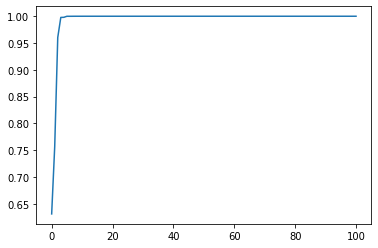

Minimo encontrado con PSO en funcion Ackley: [-2.21086966e-16 -2.21086966e-16], fn=-4.440892098500626e-16


In [6]:
# instancia optimizador PSO para minimizar la funcion ackley
pso_optimizer_ackley = PSO(ackley, 100, [-20, -20], [20, 20], 0.01, 1, 1, 100)
best_solution, best_fitness, history_bestfitness = pso_optimizer_ackley.optimize()

# muestra la evolucion del mejor fitness
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = ackley(best_solution)
print("Minimo encontrado con PSO en funcion Ackley: {}, fn={}".format(best_solution, ackley_best_solution))

 ## Probando el algoritmo ABC
 
 los parametros que se pasan a ABC son (fn, SN, Xmin, Xmax, limit, max_iter):
 
        fn: La funcion a ser minimizada
        SN: numero de fuentes de comida (Source Number)
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        limit: numero de ciclos que será conservada una solución sin mejorar antes de ser reemplazada 
        max_iter: número total de iteraciones que ejecutará ABC

<b> Optimizacion ABC en la funcion Ackley </b>

Iniciando optimizacion con Algoritmo ABC
Mejor solucion inicial = [2.37186693 2.37186693], fitness = 0.0928269252800952
Ciclo 0, Mejor solucion del ciclo = [-2.30892009 -2.30892009] (fitness = 0.09598129447573654))
Ciclo 5, Mejor solucion del ciclo = [-0.07093846 -0.07093846] (fitness = 0.6515660899728346))
Ciclo 10, Mejor solucion del ciclo = [-0.03623244 -0.03623244] (fitness = 0.8239641088063641))
Ciclo 15, Mejor solucion del ciclo = [0.00039227 0.00039227] (fitness = 0.9984252103938162))
Ciclo 20, Mejor solucion del ciclo = [-3.84427001e-05 -3.84427001e-05] (fitness = 0.9998461741606498))
Ciclo 25, Mejor solucion del ciclo = [-4.2415076e-06 -4.2415076e-06] (fitness = 0.9999830332993481))
Ciclo 30, Mejor solucion del ciclo = [5.21197255e-08 5.21197255e-08] (fitness = 0.9999997915209965))
Ciclo 35, Mejor solucion del ciclo = [8.464206e-09 8.464206e-09] (fitness = 0.9999999661431727))
Ciclo 40, Mejor solucion del ciclo = [-1.24142878e-09 -1.24142878e-09] (fitness = 0.9999999950342873)

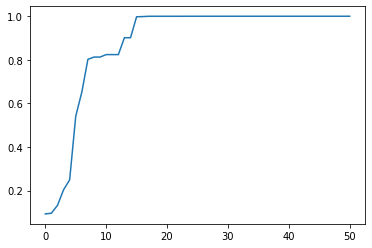

Minimo encontrado con ABC en funcion Ackley: [-1.02862059e-11 -1.02862059e-11], fn=4.114353302497875e-11


In [7]:
# instancia optimizador ABC para minimizar la funcion ackley
abc_optimizer_ackley = ABC(ackley, 5, [-20, -20], [20, 20],25, 50)
best_solution, best_fitness, history_bestfitness = abc_optimizer_ackley.optimize()

# muestra la evolucion del mejor fitness
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = ackley(best_solution)
print("Minimo encontrado con ABC en funcion Ackley: {}, fn={}".format(best_solution, ackley_best_solution))

<b> Optimizacion ABC en la funcion Rastrigin </b>

Iniciando optimizacion con Algoritmo ABC
Mejor solucion inicial = [-0.1378514 -0.1378514], fitness = 0.12372172181416644
Ciclo 0, Mejor solucion del ciclo = [0.88296407 0.88296407] (fitness = 0.12940889073621872))
Ciclo 5, Mejor solucion del ciclo = [0.05554362 0.05554362] (fitness = 0.452119420622504))
Ciclo 10, Mejor solucion del ciclo = [0.05465646 0.05465646] (fitness = 0.4600282467117639))
Ciclo 15, Mejor solucion del ciclo = [-0.00012392 -0.00012392] (fitness = 0.9999939065452504))
Ciclo 20, Mejor solucion del ciclo = [7.40735289e-06 7.40735289e-06] (fitness = 0.9999999782289))
Ciclo 25, Mejor solucion del ciclo = [4.41768996e-07 4.41768996e-07] (fitness = 0.999999999922565))
Ciclo 30, Mejor solucion del ciclo = [2.2979401e-09 2.2979401e-09] (fitness = 0.9999999999999964))
Ciclo 35, Mejor solucion del ciclo = [1.02394809e-09 1.02394809e-09] (fitness = 1.0))
Ciclo 40, Mejor solucion del ciclo = [1.02394809e-09 1.02394809e-09] (fitness = 1.0))
Ciclo 45, Mejor solucion del ciclo = [

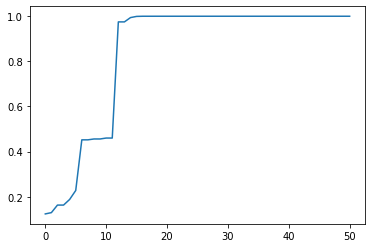

Minimo encontrado con ABC en funcion Rastrigin : [1.02394809e-09 1.02394809e-09], fn=0.0


In [8]:
# instancia optimizador ABC para minimizar la funcion Rastrigin 
abc_optimizer_rastrigin = ABC(rastrigin, 5, [-5, -5], [5, 5], 25, 50)
best_solution, best_fitness, history_bestfitness = abc_optimizer_rastrigin.optimize()

# muestra la evolucion del mejor fitness
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = rastrigin(best_solution)
print("Minimo encontrado con ABC en funcion Rastrigin : {}, fn={}".format(best_solution, ackley_best_solution))

<b> Optimizacion ABC en la funcion Rosenbrock </b>

Iniciando optimizacion con Algoritmo ABC
Mejor solucion inicial = [0.51710159 0.51710159], fitness = 0.13389432894555175
Ciclo 0, Mejor solucion del ciclo = [0.05203467 0.05203467] (fitness = 0.46686338809056743))
Ciclo 5, Mejor solucion del ciclo = [1.08035413 1.08035413] (fitness = 0.5681591250754542))
Ciclo 10, Mejor solucion del ciclo = [0.99811581 0.99811581] (fitness = 0.9996428986049289))
Ciclo 15, Mejor solucion del ciclo = [0.99811581 0.99811581] (fitness = 0.9996428986049289))
Ciclo 20, Mejor solucion del ciclo = [1.00075725 1.00075725] (fitness = 0.9999420007310107))
Ciclo 25, Mejor solucion del ciclo = [0.99994542 0.99994542] (fitness = 0.9999996991723751))
Ciclo 30, Mejor solucion del ciclo = [1.00001311 1.00001311] (fitness = 0.9999999826427223))
Ciclo 35, Mejor solucion del ciclo = [0.99999999 0.99999999] (fitness = 0.9999999999999951))
Ciclo 40, Mejor solucion del ciclo = [0.99999999 0.99999999] (fitness = 0.9999999999999951))
Ciclo 45, Mejor solucion del ciclo = [1. 1.

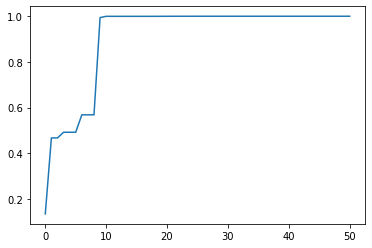

Minimo encontrado con ABC en funcion Rosenbrock : [1. 1.], fn=3.6011476158758866e-17


In [9]:
# instancia optimizador ABC para minimizar la funcion Rosenbrock 
abc_optimizer_rosenbrock = ABC(rosenbrock, 5, [-3, -3], [3, 3], 25, 50)
best_solution, best_fitness, history_bestfitness = abc_optimizer_rosenbrock.optimize()

# muestra la evolucion del mejor fitness
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = rosenbrock(best_solution)
print("Minimo encontrado con ABC en funcion Rosenbrock : {}, fn={}".format(best_solution, ackley_best_solution))